In [1]:
import os
import gc
import glob
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
#import climpred
#from climpred import HindcastEnsemble
from functools import partial
import xarray as xr
from eofs.xarray import Eof
import xesmf as xe
import xskillscore as xs
import readnc_tools as rd
import readnc2_tools as rd2
import plot_tools as pt

path_z="/cnrm/pastel/DATA/REF/era5/ncdf/daily/"
path_snow="/cnrm/pastel/USERS/ardilouzec/obs/era5_land/"
path_w="/cnrm/amacs/DATA/OBS/netcdf/6-hourly/era5/0.5x0.5/3D/"
pathout="/cnrm/pastel/USERS/ardilouzec/PLOTS/SNOW_MELT_SKILL"
lat_lims = [30,90]

In [2]:
from dask.distributed import Client, LocalCluster
#cluster=LocalCluster(n_workers=3,threads_per_worker=2)
#client.shutdown()

cluster=LocalCluster(n_workers=2)
client=Client(cluster)


In [ ]:
#Loading daily ERA5 T2M from 1993 to 2018
ref='era5'
variables=['z500']
min_lat=40 ; max_lat=53; min_lon=110; max_lon=140 #China/Russia
#min_lat=39 ; max_lat=50; min_lon=255; max_lon=290  #NAmerica
temp0=rd.read_ref(path_z,variables,ref)
#Compute daily anomalies
temp0=(temp0.groupby("time.dayofyear")-temp0.groupby("time.dayofyear").mean("time")).sel(lat=slice(30,78),lon=slice(0,360)).chunk('auto').compute()

In [4]:
ds_out = xr.Dataset(
            {
            "lat": (["lat"], np.arange(30.5, 78.5, 1.5)),
            "lon": (["lon"], np.arange(0, 360, 1.5)),
            })

regridder = xe.Regridder(temp0, ds_out, "bilinear",periodic=True)
temp0=regridder(temp0,keep_attrs=True)
print(temp0)

<xarray.Dataset>
Dimensions:    (time: 14610, lat: 32, lon: 240)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2018-12-31
    dayofyear  (time) int64 1 2 3 4 5 6 7 8 ... 358 359 360 361 362 363 364 365
  * lat        (lat) float64 30.5 32.0 33.5 35.0 36.5 ... 72.5 74.0 75.5 77.0
  * lon        (lon) float64 0.0 1.5 3.0 4.5 6.0 ... 354.0 355.5 357.0 358.5
Data variables:
    z500       (time, lat, lon) float32 0.0 99.21 0.0 ... -67.69 -71.94 -76.17
Attributes:
    regrid_method:  bilinear


In [5]:
#Loading daily ERA5 u v winds 300 & 500 hPa from 1993 to 2018
ficu,ficv=glob.glob(path_w+'era5_plev_ua_[12][90][78901]*nc'),glob.glob(path_w+'era5_plev_va_[12][90][78901]*nc')
ficu.sort(); ficv.sort()
#print(ficuv)
def prepro(ds):
 ds=ds.sel({'plev':[30000,50000]}).isel(time=ds['time'].dt.month.isin([2,3,4])).resample(time='1D').mean()
 regridder = xe.Regridder(ds, ds_out, "bilinear",periodic=True)
 ds=regridder(ds,keep_attrs=True)
 try:
  ds2=ds.rename({'latitude': 'lat','longitude':'lon'})
 except:
  ds2=ds
 return ds2.sortby(ds2.lat)
 
#ds1 = xr.open_mfdataset(ficu, chunks = {'time': 1000}, preprocess=prepro)
import dask
dask.config.set({"array.slicing.split_large_chunks": False})
dsv = xr.open_mfdataset(ficv, preprocess=prepro)
dsv=dsv.sel(lat=slice(30,78))
print(dsv)

<xarray.Dataset>
Dimensions:  (time: 3570, plev: 2, lat: 32, lon: 240)
Coordinates:
  * plev     (plev) float64 3e+04 5e+04
  * time     (time) datetime64[ns] 1979-02-01 1979-02-02 ... 2018-04-30
  * lat      (lat) float64 30.5 32.0 33.5 35.0 36.5 ... 71.0 72.5 74.0 75.5 77.0
  * lon      (lon) float64 0.0 1.5 3.0 4.5 6.0 ... 352.5 354.0 355.5 357.0 358.5
Data variables:
    va       (time, plev, lat, lon) float32 dask.array<chunksize=(1, 2, 32, 240), meta=np.ndarray>
Attributes:
    CDI:            Climate Data Interface version 1.8.2 (http://mpimet.mpg.d...
    Conventions:    CF-1.6
    history:        Fri Mar 15 21:03:23 2019: cdo cat era5_plev_va_197901.nc ...
    CDO:            Climate Data Operators version 1.8.2 (http://mpimet.mpg.d...
    regrid_method:  bilinear


In [6]:
def prepro(ds):
 ds=ds.sel({'plev':30000}).isel(time=ds['time'].dt.month.isin([2,3,4])).resample(time='1D').mean()
 regridder = xe.Regridder(ds, ds_out, "bilinear",periodic=True)
 ds=regridder(ds,keep_attrs=True)
 try: 
  ds2=ds.rename({'latitude': 'lat','longitude':'lon'})
 except:
  ds2=ds
 return ds2.sortby(ds2.lat).chunk('auto')
dsu = xr.open_mfdataset(ficu, preprocess=prepro)
dsu=dsu.sel(lat=slice(30,78))
print(dsu)
dsu=dsu.chunk('auto').compute()

<xarray.Dataset>
Dimensions:  (time: 3570, lat: 32, lon: 240)
Coordinates:
    plev     float64 3e+04
  * time     (time) datetime64[ns] 1979-02-01 1979-02-02 ... 2018-04-30
  * lat      (lat) float64 30.5 32.0 33.5 35.0 36.5 ... 71.0 72.5 74.0 75.5 77.0
  * lon      (lon) float64 0.0 1.5 3.0 4.5 6.0 ... 352.5 354.0 355.5 357.0 358.5
Data variables:
    ua       (time, lat, lon) float32 dask.array<chunksize=(89, 32, 240), meta=np.ndarray>
Attributes:
    CDI:            Climate Data Interface version 1.8.2 (http://mpimet.mpg.d...
    Conventions:    CF-1.6
    history:        Fri Mar 15 19:48:21 2019: cdo cat era5_plev_ua_197901.nc ...
    CDO:            Climate Data Operators version 1.8.2 (http://mpimet.mpg.d...
    regrid_method:  bilinear


In [7]:
dsv=dsv.compute()
print(dsv)

<xarray.Dataset>
Dimensions:  (time: 3570, plev: 2, lat: 32, lon: 240)
Coordinates:
  * plev     (plev) float64 3e+04 5e+04
  * time     (time) datetime64[ns] 1979-02-01 1979-02-02 ... 2018-04-30
  * lat      (lat) float64 30.5 32.0 33.5 35.0 36.5 ... 71.0 72.5 74.0 75.5 77.0
  * lon      (lon) float64 0.0 1.5 3.0 4.5 6.0 ... 352.5 354.0 355.5 357.0 358.5
Data variables:
    va       (time, plev, lat, lon) float32 -18.94 -15.72 -14.94 ... 6.1 4.814
Attributes:
    CDI:            Climate Data Interface version 1.8.2 (http://mpimet.mpg.d...
    Conventions:    CF-1.6
    history:        Fri Mar 15 21:03:23 2019: cdo cat era5_plev_va_197901.nc ...
    CDO:            Climate Data Operators version 1.8.2 (http://mpimet.mpg.d...
    regrid_method:  bilinear


In [8]:
#Loading daily ERA5Land Snow depth Water equivalent from 1993 to 2018 (February to May only)
var='sd'; var2=var; v2drop = ['time_bnds']
#years = [x for x in range(1979,2019)]
files = os.listdir(path_snow+var2+'/')
files.sort()
fic = [path_snow+var2+'/'+fi for fi in files[:-2]]
def prepro(ds):
 regridder= xe.Regridder(ds, ds_out, "bilinear",periodic=True)  
 ds=regridder(ds,keep_attrs=True)
 return ds.chunk('auto')
sn=xr.open_mfdataset(fic,preprocess=prepro, drop_variables = v2drop )
#sn=rd.read_ref(path_snow,variables,ref)
sn=sn.groupby("time.dayofyear")-sn.groupby("time.dayofyear").mean("time")
sn=sn.rename({'sd':'snow'}).chunk('auto').compute()
print(sn)

/home/ardilouzec/miniconda3/lib/python3.8/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 41 times more chunks
  return self.array[key]


<xarray.Dataset>
Dimensions:    (time: 4930, lat: 32, lon: 240)
Coordinates:
  * time       (time) datetime64[ns] 1979-02-01 1979-02-02 ... 2019-05-31
  * lat        (lat) float64 30.5 32.0 33.5 35.0 36.5 ... 72.5 74.0 75.5 77.0
  * lon        (lon) float64 0.0 1.5 3.0 4.5 6.0 ... 354.0 355.5 357.0 358.5
    dayofyear  (time) int64 32 33 34 35 36 37 38 ... 145 146 147 148 149 150 151
Data variables:
    snow       (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan


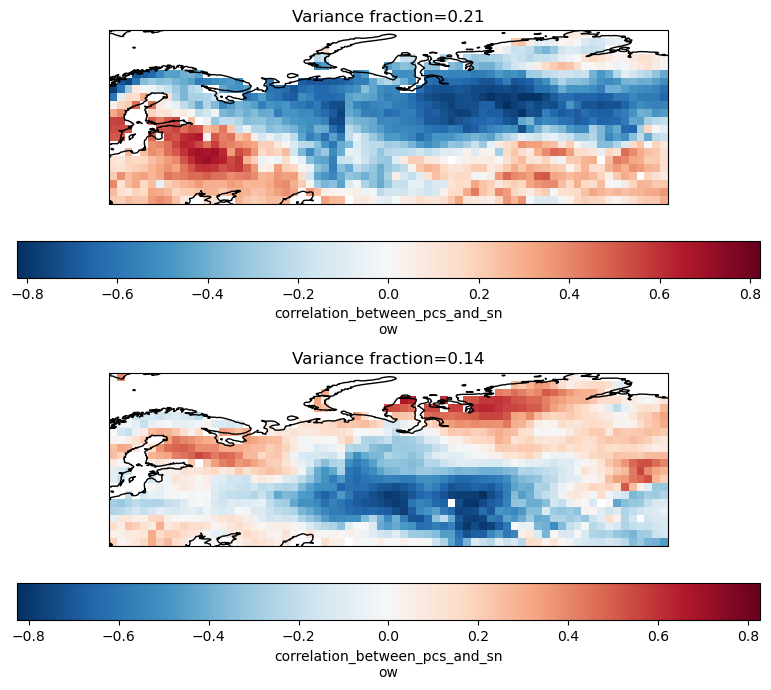

In [56]:
#Extract Snow depth time comprised between 17 Feb and 18 March (representative of early spring initialization)
snmonth=sn.where(((sn.time.dt.month==2)&(sn.time.dt.day>=17))|((sn.time.dt.month==3)&(sn.time.dt.day<=18))).dropna(dim='time',how='all')
#Extract Eurasian domain, compute EOFs and plot the first EOF with fraction of explained variance
sneof=snmonth.snow.sel(lat=slice(45,78),lon=slice(15,120)) 
#sneof=snmonth.snow.sel(lat=slice(45,78),lon=slice(10,70))
#sneof=snmonth.snow.sel(lat=slice(45,70),lon=slice(60,120))
#sneofUS=snmonth.snow.sel(lat=slice(45,65),lon=slice(245,285))
coslat= np.cos(np.deg2rad(sneof.coords['lat'].values)).clip(0., 1.)
wgts = np.sqrt(coslat)[..., np.newaxis]*(-1)
solver=Eof(sneof,weights=wgts)
eofs=solver.eofsAsCorrelation(neofs=3)
expl_var=solver.varianceFraction(neigs=3)
fig,axs = plt.subplots(nrows=2,figsize=(10, 7),subplot_kw=dict(projection=ccrs.PlateCarree()))
p=eofs[0].plot(ax=axs[0],transform=ccrs.PlateCarree(),cbar_kwargs={"orientation":"horizontal"})
axs[0].set_title('Variance fraction='+str(np.round(expl_var[0].values,2)))
#pcs=solver.pcs(npcs=3)
p=eofs[1].plot(ax=axs[1],transform=ccrs.PlateCarree(),cbar_kwargs={"orientation":"horizontal"})
axs[1].set_title('Variance fraction='+str(np.round(expl_var[1].values,2)))
[ax.coastlines() for ax in axs.flatten()]
plt.tight_layout()


### First two EOFs of daily ERA5-Land snow depth comprised between 17 Feb and 18 March 1979-2019 

[1980 1982 1985 1986 1987 1988 1994 1999 2000 2001 2003 2004 2005 2006
 2009 2010 2011 2012 2013 2018]
[1979 1981 1983 1984 1989 1990 1991 1992 1993 1995 1996 1997 1998 2002
 2007 2008 2014 2015 2016 2017 2019]
[1985 2006 2010 2011 2012 2013]
[1983 1989 1990 1993 2002 2015]


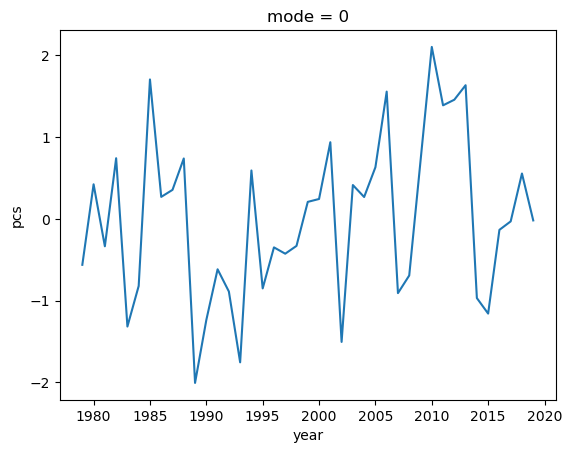

In [57]:
#daily Principal components scaled to unit variance 
pc1=solver.pcs(npcs=3, pcscaling=1)*(-1)
#trick to better represent time axix in plot
a=xr.DataArray(pc1[:,0],dims=['time'])
#Yearly averaging the time series associated to PC1 and plotting:
a=a.groupby('time.year').mean('time')
a.plot()

ap=a.where(a>0).dropna(dim='year').year.values
an=a.where(a<0).dropna(dim='year').year.values
print(ap);print(an)
app=a.where(a>a.std()).dropna(dim='year').year.values
ann=a.where(a<(-1*a.std())).dropna(dim='year').year.values
print(app);print(ann)


### Time series of the principal component associated to snow cover EOF1

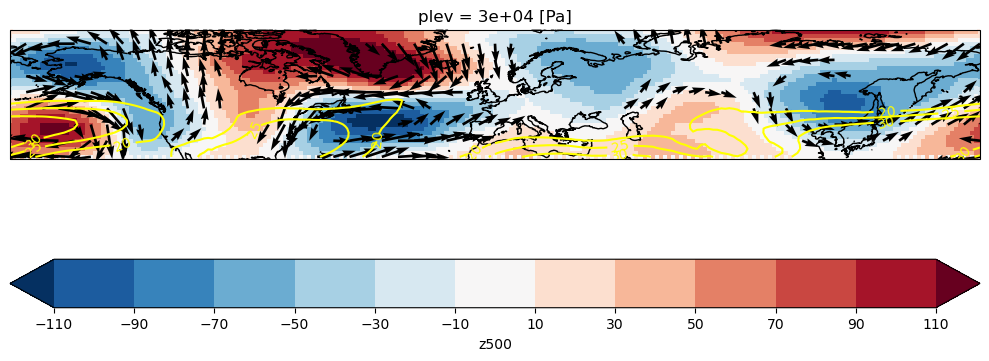

In [62]:
temp1=temp0.rolling(time=30).mean().where((temp0.time.dt.month==4)&(temp0.time.dt.day==15)).dropna(dim='time')
jetu=dsu.rolling(time=30).mean().where((dsu.time.dt.month==4)&(dsu.time.dt.day==15)).dropna(dim='time')
jetv=dsv.sel(plev=30000).rolling(time=30).mean(['time','plev']).where((dsv.time.dt.month==4)&(dsv.time.dt.day==15)).dropna(dim='time')
delta=temp1.sel(time=temp1.time.dt.year.isin(app)).mean('time')-temp1.sel(time=temp1.time.dt.year.isin(ann)).mean('time')
delta2=temp1.sel(time=temp1.time.dt.year.isin(ap)).mean('time')-temp1.sel(time=temp1.time.dt.year.isin(an)).mean('time')
deltajetu=jetu.sel(time=jetu.time.dt.year.isin(app)).mean('time')-jetu.sel(time=jetu.time.dt.year.isin(ann)).mean('time')
deltajetv=jetv.sel(time=jetv.time.dt.year.isin(app)).mean('time')-jetv.sel(time=jetv.time.dt.year.isin(ann)).mean('time')

levels=[i for i in range(-110,130,20)]
fig,axs=plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()),figsize=(10,7))
p=delta.z500.plot(ax=axs,transform=ccrs.PlateCarree(),cbar_kwargs={"orientation":"horizontal",'ticks':levels},levels=levels,extend='both')
p.axes.coastlines()
#g=deltajetu.ua.plot.contour(ax=axs[0],levels=[-8,-5,5,8],colors='black')
g=jetu.ua.mean('time').plot.contour(ax=axs,levels=[20,25,30],colors='yellow')
g.axes.clabel(g,inline=1,inline_spacing=2,fontsize=10,fmt='%1.0f')
skip=dict(lat=slice(None,None,4),lon=slice(None,None,4))
speed=np.sqrt(deltajetu.ua**2+deltajetv.va**2)
deltajetu=deltajetu.where(speed>6); deltajetv=deltajetv.where(speed>6)
#h=axs[0].quiver(jetu.lon.isel(lon=slice(None,None,4)), jetu.lat.isel(lat=slice(None,None,4)),jetu.ua.mean('time').isel(skip),jetv.va.mean('time').isel(skip))
h=axs.quiver(deltajetu.lon.isel(lon=slice(None,None,4)), deltajetu.lat.isel(lat=slice(None,None,4)),deltajetu.ua.isel(skip),deltajetv.va.isel(skip))
#p2=delta2.z500.plot(ax=axs[1],transform=ccrs.PlateCarree(),add_colorbar=False,levels=levels,extend='both')
#p2.axes.coastlines()
plt.tight_layout()

### Composite anomalies of Z500 (shades) and wind at 300 hPa (vectors) and mean zonal wind (yellow contours) for 30-day averages centered around April 1st

In [50]:
# we compute 7-day and 30-day rolling mean for temperature (weekly anomalies) but nor for snow (to comply with subseasonal forecast context)
#snow=sn.rolling(time=7).mean().dropna(dim='time',how='all')
hovp=dsv.rolling(time=14).mean().sel(time=dsv.time.dt.year.isin(app)).dropna('time').groupby('time.dayofyear').mean().sel(dayofyear=slice(58,105),lat=slice(40,65),lon=slice(60,140)).mean('lat')
hovm=dsv.rolling(time=14).mean().sel(time=dsv.time.dt.year.isin(ann)).dropna('time').groupby('time.dayofyear').mean().sel(dayofyear=slice(58,105),lat=slice(40,65),lon=slice(60,140)).mean('lat')
delta=hovp-hovm
zp=temp0.rolling(time=14).mean().sel(time=temp0.time.dt.year.isin(app)).dropna('time').groupby('time.dayofyear').mean().sel(dayofyear=slice(58,105),lat=slice(40,65),lon=slice(60,140)).mean('lat')
zm=temp0.rolling(time=14).mean().sel(time=temp0.time.dt.year.isin(ann)).dropna('time').groupby('time.dayofyear').mean().sel(dayofyear=slice(58,105),lat=slice(40,65),lon=slice(60,140)).mean('lat')
deltaz=zp-zm
#print(hovp)
#print(hovm)
print(delta)

<xarray.Dataset>
Dimensions:    (plev: 2, lon: 54, dayofyear: 48)
Coordinates:
  * plev       (plev) float64 3e+04 5e+04
  * lon        (lon) float64 60.0 61.5 63.0 64.5 ... 135.0 136.5 138.0 139.5
  * dayofyear  (dayofyear) int64 58 59 60 61 62 63 ... 100 101 102 103 104 105
Data variables:
    va         (dayofyear, plev, lon) float32 0.5719 0.2607 ... 0.4735 0.6783


<a list of 23 text.Text objects>

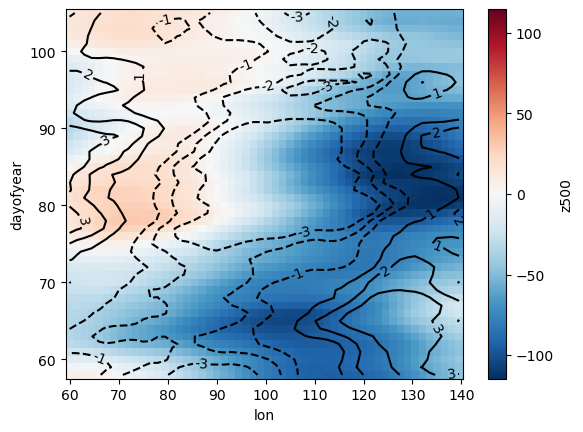

In [51]:
#delta.va.sel(plev=['50000']).plot()
#p=deltaz.z500.plot.contour(levels=[-80,-50,-20,20,50,80],colors='black')
#p.axes.clabel(p,inline=1,inline_spacing=2,fontsize=10,fmt='%1.0f')
deltaz.z500.plot()
p=delta.va.sel(plev=['50000']).mean('plev').plot.contour(levels=[-3,-2,-1,1,2,3],colors='black')
p.axes.clabel(p,inline=1,inline_spacing=2,fontsize=10,fmt='%1.0f')

### Hovmoller diagram of 30-day running mean Z500 (shades) and 300 hPa meridional wind composite anomalies between 28 Feb and 15 April

## Same thing for North America

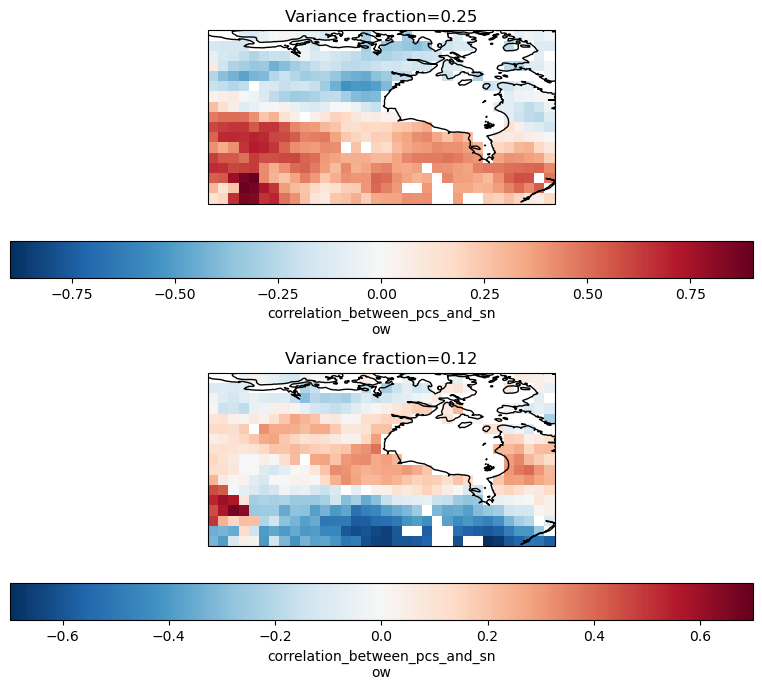

In [63]:
sneof=snmonth.snow.sel(lat=slice(45,70),lon=slice(240,290))
#sneof=snmonth.snow.sel(lat=slice(45,65),lon=slice(240,290))
coslat= np.cos(np.deg2rad(sneof.coords['lat'].values)).clip(0., 1.)
wgts = np.sqrt(coslat)[..., np.newaxis]
solver=Eof(sneof,weights=wgts)
eofs=solver.eofsAsCorrelation(neofs=3)
expl_var=solver.varianceFraction(neigs=3)
fig,axs = plt.subplots(nrows=2,figsize=(10, 7),subplot_kw=dict(projection=ccrs.PlateCarree()))
p=eofs[0].plot(ax=axs[0],transform=ccrs.PlateCarree(),cbar_kwargs={"orientation":"horizontal"})
axs[0].set_title('Variance fraction='+str(np.round(expl_var[0].values,2)))
#pcs=solver.pcs(npcs=3)
p=eofs[1].plot(ax=axs[1],transform=ccrs.PlateCarree(),cbar_kwargs={"orientation":"horizontal"})
axs[1].set_title('Variance fraction='+str(np.round(expl_var[1].values,2)))
[ax.coastlines() for ax in axs.flatten()]
plt.tight_layout()

### First two EOFs of daily ERA5-Land snow depth comprised between 17 Feb and 18 March 1979-2019 

[1982 1996 1997 1999 2018]
[1981 1988 1993 2001 2005 2010]


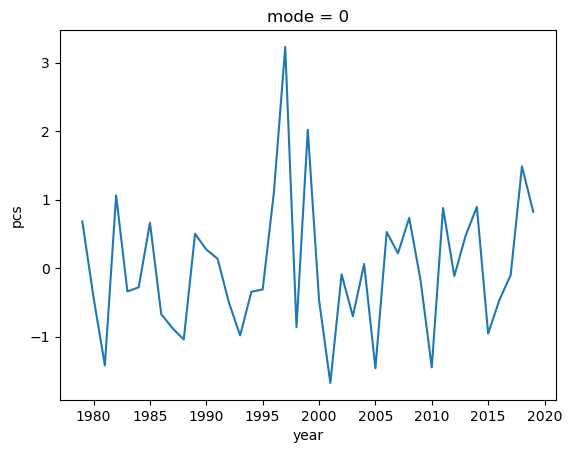

In [65]:
pc1=solver.pcs(npcs=3, pcscaling=1)
#trick to better represent time axix in plot
a=xr.DataArray(pc1[:,0],dims=['time'])
#Yearly averaging the time series associated to PC1 and plotting:
a=a.groupby('time.year').mean('time')
a.plot()
ap=a.where(a>0).dropna(dim='year').year.values
an=a.where(a<0).dropna(dim='year').year.values
#print(ap);print(an)
app=a.where(a>(1*a.std())).dropna(dim='year').year.values
ann=a.where(a<(-1*a.std())).dropna(dim='year').year.values
print(app);print(ann)

### Time series of the principal component associated to snow cover EOF1

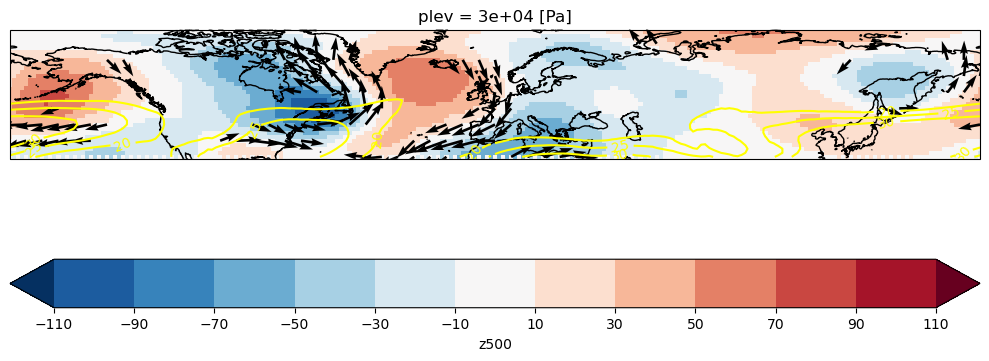

In [67]:
temp1=temp0.rolling(time=30).mean().where((temp0.time.dt.month==4)&(temp0.time.dt.day==15)).dropna(dim='time')
delta=temp1.sel(time=temp1.time.dt.year.isin(app)).mean('time')-temp1.sel(time=temp1.time.dt.year.isin(ann)).mean('time')
delta2=temp1.sel(time=temp1.time.dt.year.isin(ap)).mean('time')-temp1.sel(time=temp1.time.dt.year.isin(an)).mean('time')
deltajetu=jetu.sel(time=jetu.time.dt.year.isin(app)).mean('time')-jetu.sel(time=jetu.time.dt.year.isin(ann)).mean('time')
deltajetv=jetv.sel(time=jetv.time.dt.year.isin(app)).mean('time')-jetv.sel(time=jetv.time.dt.year.isin(ann)).mean('time')
levels=[i for i in range(-110,130,20)]
fig,axs=plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()),figsize=(10,7))
p=delta.z500.plot(ax=axs,transform=ccrs.PlateCarree(),cbar_kwargs={"orientation":"horizontal",'ticks':levels},levels=levels,extend='both')
p.axes.coastlines()
g=jetu.ua.mean('time').plot.contour(ax=axs,levels=[20,25,30],colors='yellow')
g.axes.clabel(g,inline=1,inline_spacing=2,fontsize=10,fmt='%1.0f')
skip=dict(lat=slice(None,None,4),lon=slice(None,None,4))
speed=np.sqrt(deltajetu.ua**2+deltajetv.va**2)
deltajetu=deltajetu.where(speed>6); deltajetv=deltajetv.where(speed>6)
#h=axs[0].quiver(jetu.lon.isel(lon=slice(None,None,4)), jetu.lat.isel(lat=slice(None,None,4)),jetu.ua.mean('time').isel(skip),jetv.va.mean('time').isel(skip))
h=axs.quiver(deltajetu.lon.isel(lon=slice(None,None,4)), deltajetu.lat.isel(lat=slice(None,None,4)),deltajetu.ua.isel(skip),deltajetv.va.isel(skip))
#p2=delta2.z500.plot(ax=axs[1],transform=ccrs.PlateCarree(),add_colorbar=False,levels=levels,extend='both')
#p2.axes.coastlines()
plt.tight_layout()

### Composite anomalies of Z500 (shades) and wind at 300 hPa (vectors) and mean zonal wind (yellow contours) for 30-day averages centered around April 1st

In [68]:
# we compute 7-day and 30-day rolling mean for temperature (weekly anomalies) but nor for snow (to comply with subseasonal forecast context)
#snow=sn.rolling(time=7).mean().dropna(dim='time',how='all')
hovp=dsv.rolling(time=14).mean().sel(time=dsv.time.dt.year.isin(app)).dropna('time').groupby('time.dayofyear').mean().sel(dayofyear=slice(58,105),lat=slice(39,50),lon=slice(240,305)).mean('lat')
hovm=dsv.rolling(time=14).mean().sel(time=dsv.time.dt.year.isin(ann)).dropna('time').groupby('time.dayofyear').mean().sel(dayofyear=slice(58,105),lat=slice(39,50),lon=slice(240,305)).mean('lat')
delta=hovp-hovm
zp=temp0.rolling(time=14).mean().sel(time=temp0.time.dt.year.isin(app)).dropna('time').groupby('time.dayofyear').mean().sel(dayofyear=slice(58,105),lat=slice(39,50),lon=slice(240,305)).mean('lat')
zm=temp0.rolling(time=14).mean().sel(time=temp0.time.dt.year.isin(ann)).dropna('time').groupby('time.dayofyear').mean().sel(dayofyear=slice(58,105),lat=slice(39,50),lon=slice(240,305)).mean('lat')
deltaz=zp-zm
#print(hovp)
#print(hovm)
print(delta)

<xarray.Dataset>
Dimensions:    (plev: 2, lon: 44, dayofyear: 48)
Coordinates:
  * plev       (plev) float64 3e+04 5e+04
  * lon        (lon) float64 240.0 241.5 243.0 244.5 ... 300.0 301.5 303.0 304.5
  * dayofyear  (dayofyear) int64 58 59 60 61 62 63 ... 100 101 102 103 104 105
Data variables:
    va         (dayofyear, plev, lon) float32 -0.8496 -0.1873 ... 3.454 4.099


<a list of 25 text.Text objects>

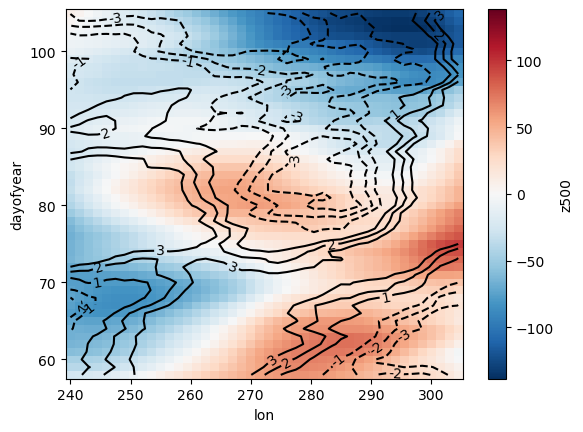

In [69]:
#delta.va.sel(plev=['50000']).plot()
#p=deltaz.z500.plot.contour(levels=[-60,-40,-20,20,40,60],colors='black')
#p.axes.clabel(p,inline=1,inline_spacing=2,fontsize=10,fmt='%1.0f')
deltaz.z500.plot()
p=delta.va.sel(plev=['50000']).mean('plev').plot.contour(levels=[-3,-2,-1,1,2,3],colors='black')
p.axes.clabel(p,inline=1,inline_spacing=2,fontsize=10,fmt='%1.0f')

### Hovmoller diagram of 30-day running mean Z500 (shades) and 300 hPa meridional wind composite anomalies between 28 Feb and 15 April

/home/ardilouzec/miniconda3/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/ardilouzec/miniconda3/lib/python3.8/site-packages/xskillscore/core/deterministic.py:462: UserWarning: ['year'] is not 'time'. Make sure that you are applying this over a temporal dimension.
  warnings.warn(
/home/ardilouzec/miniconda3/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/ardilouzec/miniconda3/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den


Text(0.5, 1.0, 'Correlation of average 18 March-15 April 2m temperature anomaly (ERA5) averaged over the red box with average 17 Feb- 18 March snow depth water equivalent (ERA5-Land)')

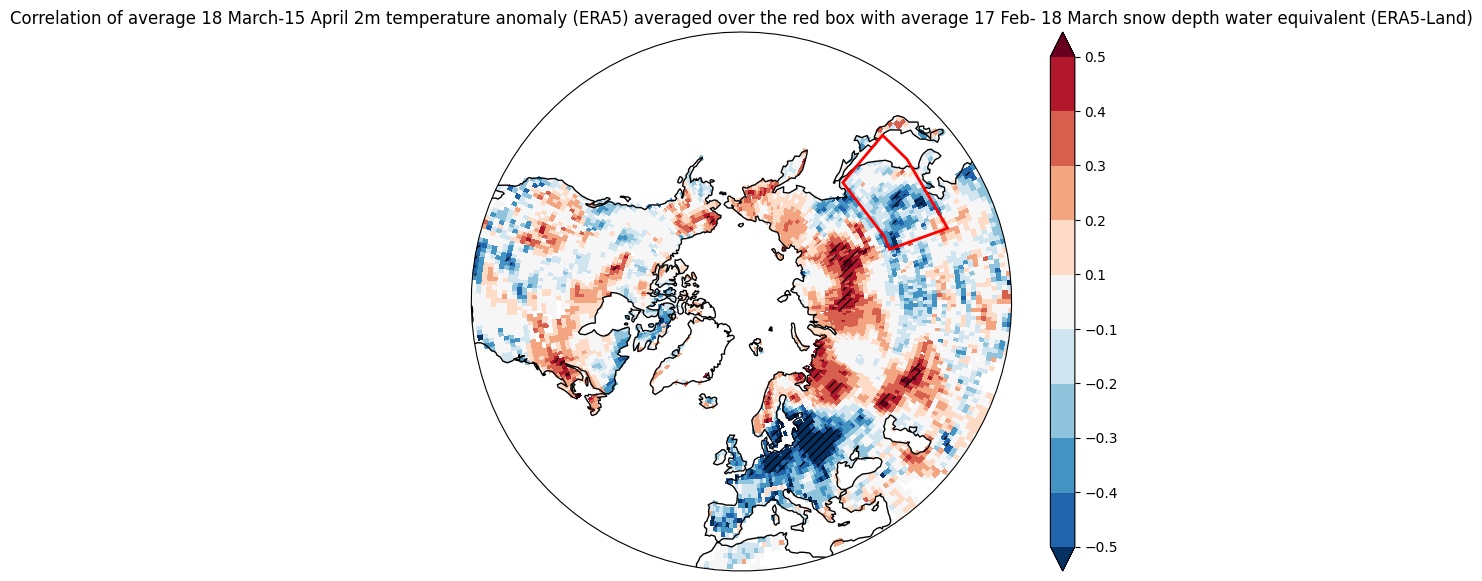

In [67]:
#Plot the pearson correlation and hatch significant values at the 0.05% confidence level
#between yearly averages of 17 Feb to 18 March snow and 18March to 15April Red box 2m Temperature 
levels = [np.round(x,2) for x in np.arange(-0.5,0.6,0.1) ]
levels.remove(0)
fig = plt.figure(figsize=(10, 7))
p=xs.pearson_r(snmonth.snow.groupby('time.year').mean('time'),detrended_temp,dim='year').sel(lat=slice(0,80)).plot(x='lon',y='lat',levels=levels,extend='both',transform=ccrs.PlateCarree(),subplot_kws=dict(projection=ccrs.NorthPolarStereo()))
s=xs.pearson_r_eff_p_value(snmonth.snow.groupby('time.year').mean('time'),detrended_temp,dim='year').sel(lat=slice(0,80))
s=s.where(s<=0.05)
s.plot.contourf('lon','lat',ax=p.axes,colors='None',add_colorbar=False,hatches=[4*'/'],transform=ccrs.PlateCarree(),alpha=0)
pt.polarCentral_set_latlim(lat_lims,p.axes)
p.axes.coastlines()
p.axes.add_patch(mpatches.Rectangle(zorder=2,xy=[110, 40], width=30, height=13, facecolor='none',edgecolor='red',linewidth=2,transform=ccrs.PlateCarree()))
#p.axes.add_patch(mpatches.Rectangle(zorder=2,xy=[255, 39], width=35, height=11, facecolor='none',edgecolor='red',linewidth=2,transform=ccrs.PlateCarree()))
plt.title("Correlation of average 18 March-15 April 2m temperature anomaly (ERA5) averaged over the red box with average 17 Feb- 18 March snow depth water equivalent (ERA5-Land)")

In [30]:
# Same idea as bove, but mimicking subseasonal forecasting
#We keep only the 25 Feb, 4 March, 11 March and 18 March for snow depth water equivalent anomalies
sn=sn.where(((sn.time.dt.month==2) & (sn.time.dt.day==25)) | ((sn.time.dt.month==3) & (np.isin(sn.time.dt.day,[4,11,18])))).dropna(dim='time',how='all')
#We keep for each year the 4 corresponding 7-day rolling mean temperature 25 days after the snow dates
test_temp=temp2.shift(time=-25).reindex({'time':sn.time}) #Reminder: temp2 = 7-day rolling mean temperature. 

/home/ardilouzec/miniconda3/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/ardilouzec/miniconda3/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/ardilouzec/miniconda3/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den


Text(0.5, 1.0, "Correlation of 'week 4' 2m temperature anomaly (ERA5) averaged over the red box with initial snow depth water equivalent (ERA5-Land)")

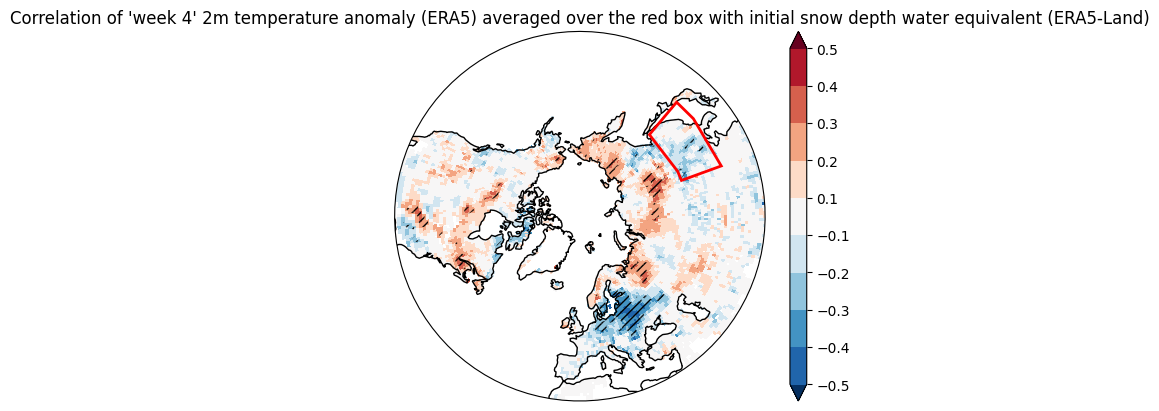

In [31]:
#Plot the pearson correlation and hatch significant values at the 0.05% confidence level
levels = [np.round(x,2) for x in np.arange(-0.5,0.6,0.1) ]
levels.remove(0)
p=xs.pearson_r(sn.snow,test_temp.t2m,dim='time').sel(lat=slice(0,80)).plot(x='lon',y='lat',levels=levels,extend='both',transform=ccrs.PlateCarree(),subplot_kws=dict(projection=ccrs.NorthPolarStereo()))
s=xs.pearson_r_eff_p_value(sn.snow,test_temp.t2m,dim='time').sel(lat=slice(0,80))
s=s.where(s<=0.05)
s.plot.contourf('lon','lat',ax=p.axes,colors='None',add_colorbar=False,hatches=[4*'/'],transform=ccrs.PlateCarree(),alpha=0)
pt.polarCentral_set_latlim(lat_lims,p.axes)
p.axes.coastlines()
p.axes.add_patch(mpatches.Rectangle(zorder=2,xy=[110, 40], width=30, height=13, facecolor='none',edgecolor='red',linewidth=2,transform=ccrs.PlateCarree()))
#p.axes.add_patch(mpatches.Rectangle(zorder=2,xy=[250, 37], width=40, height=13, facecolor='none',edgecolor='red',linewidth=2,transform=ccrs.PlateCarree()))
plt.title("Correlation of 'week 4' 2m temperature anomaly (ERA5) averaged over the red box with initial snow depth water equivalent (ERA5-Land)")

Text(0.5, 1.0, 'Mean snow evolution btwn 25 Feb.and 18 March')

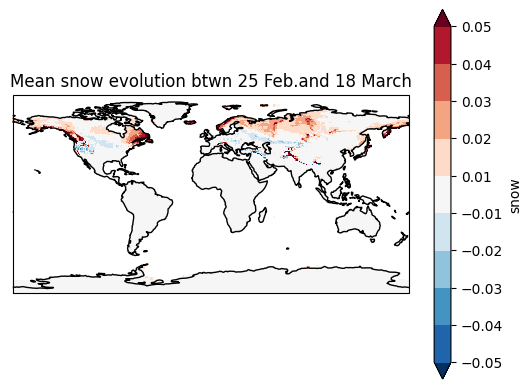

In [32]:
#Not very informative plot: Mean snow depth evolution btwn 25 Feb.and 18 March
ref='era5land'
variables=['sd']
snfull=rd.read_ref(path_snow,variables,ref).compute()
snfull=snfull.rename({'sd':'snow'})

levels = [np.round(x,2) for x in np.arange(-0.05,0.06,0.01) ]
levels.remove(0)
g=snfull.where((snfull.time.dt.month==3) & (snfull.time.dt.day==18)).dropna(dim='time',how='all')
f=snfull.where((snfull.time.dt.month==2) & (snfull.time.dt.day==25)).dropna(dim='time',how='all')
#a.sd.mean('time').plot(levels=[np.round(x,2) for x in np.arange(0,0.55,0.05)])
p=(g.snow.mean('time')-f.snow.mean('time')).plot(levels=levels,transform=ccrs.PlateCarree(),subplot_kws=dict(projection=ccrs.PlateCarree()))
p.axes.coastlines()
plt.title("Mean snow evolution btwn 25 Feb.and 18 March")